In [3]:
#
# phase1 - scaling:
#   trying to do inference on larger magnitudes
#

%matplotlib inline
import os
os.environ['THEANO_FLAGS'] = "mode=FAST_RUN,device=cpu,floatX=float32"
import theano
import theano.tensor as T
import config
import numpy as np
import matplotlib.pyplot as plt

/Library/Python/2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
import network
import network.normFlow as nf
import utils
import utils.mathT as mathT
import utils.mathZ as mathZ
import utils.theanoGeneral as utilsT
import utils.optimizers as optimizers
import utils.plotZ as plotZ
# import seaborn as sns
floatX = utils.floatX

In [56]:
# parameter setup
DIM = 2
SAVE_FLAG = False
# FIG_PATH  = '../report/figs/gmm/'+Z0_TYPE

# p(z) to approximate
means   = np.asarray( [[8,2.0],[-1.5,-1.5],[-2.0,1.0]] )
varmats = np.asarray( [np.eye(2)*2, np.eye(2)*2, np.eye(2)*3] ) 
weights = np.asarray( [0.4,0.3,0.3] )
logTarget = mathT.multiGmm(means, varmats,weights)


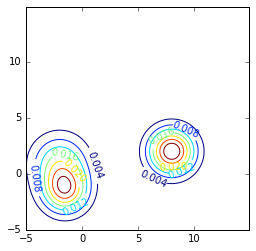

In [57]:
# true p(z)
LOW, HIGH, GAP = -5, +15, 0.1
fgmm = mathZ.multiGmmInit(means,varmats,weights)
gz, g1, g2 = mathZ.gridPoints( (LOW, HIGH, GAP), (LOW, HIGH, GAP) )
gpz = np.exp( fgmm(gz).reshape(g1.shape[1],g2.shape[0]) )
fig = plt.figure()
CS = plt.contour(g1,g2,gpz)
plt.clabel(CS, inline=1, fontsize=10)
plt.axes().set_aspect('equal')
if SAVE_FLAG:
    plt.savefig(FIG_PATH+'/gmm.png')
plt.show()

In [58]:
# construction variational model
# Z0_TYPE = 'normal'
# STD = 8
Z0_TYPE = 'uniform'
STD = 16
SAMPLINGNUM = 20
NUM_LAYERS = 8
NUMITER = 9000
ziters = [0,19,49,99,199,999,1999,NUMITER-1]



iaf = nf.NormFlowModel( dim=DIM, numlayers=NUM_LAYERS, noisestd=STD, z0type=Z0_TYPE )  #(4./DIM)**.5
e = iaf.getNoiseVar(SAMPLINGNUM)
z, logqz = iaf.reparam(e)

# setting cost variable
logpz = logTarget(z)
cost = T.mean( logqz - logpz ) # KL cost

params = iaf.getParams()
grads = [ T.grad(cost,p,consider_constant=[e]) for p in params ]

In [59]:
# optimisation setup
iaf.reInit()
opt = optimizers.SGD(params,lr=0.05,momentum=0.5,decay=0.0005)
updates = opt.getUpdates(params,grads)

outputs = [ cost, T.mean(logpz), T.mean(logqz) ]
estep = theano.function(inputs=[],outputs=outputs,updates=updates)

In [60]:
# for presentation
PRENUM = 50000
e2 = iaf.getNoiseVar(PRENUM)
z2, logqz2 = iaf.reparam(e2)
fez2 = theano.function(inputs=[],outputs=[e2,z2])

In [64]:
ess, zss = fez2()
print ess.shape, zss.shape

(50000, 2) (50000, 2)


In [61]:
# training

keys = ['cost','pz','qz']
record = {'zs':[]}

for k in keys:
    record[k] = []
    
zset = set(ziters)
for i in range(NUMITER):
    out = estep()
    for k,q in enumerate(out):
        record[keys[k]].append( q )
    if i in zset:
        print 'samples of iter %d'%i
        record['zs'].append(fez2()[1])
        
for k in keys:
    record[k] = np.asarray( record[k] )

samples of iter 0
samples of iter 19
samples of iter 49
samples of iter 99
samples of iter 199
samples of iter 999
samples of iter 1999
samples of iter 8999


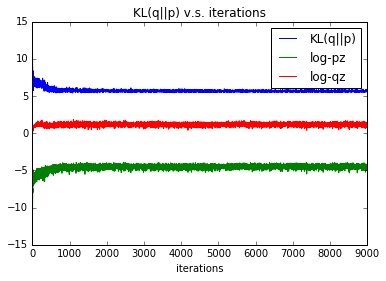

In [81]:
xs = np.arange(NUMITER)+1
plt.plot( xs, record['cost'], '-', label='KL(q||p)')
plt.xlabel('iterations')
plt.title('KL(q||p) v.s. iterations')
if SAVE_FLAG:
    plt.savefig(FIG_PATH+'/L%d_kl.png'%(NUM_LAYERS))
    np.savez(FIG_PATH+'/record_L%d.npz'%NUM_LAYERS,cost=record['cost'],numiter=NUMITER,numlayers=NUM_LAYERS)
plt.plot( xs, record['pz'], '-', label='log-pz')
plt.plot( xs, record['qz'], '-', label='log-qz')
plt.legend()
plt.show()

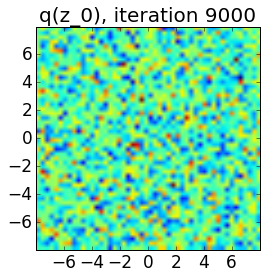

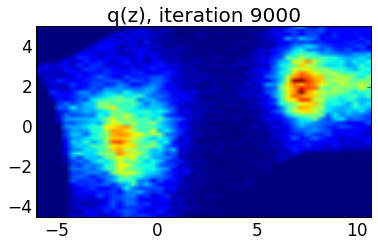

In [83]:
ess, zss = fez2()

# plot q(z_0)
hmp_e, xe_e, ye_e = np.histogram2d( ess[:,0], ess[:,1], bins=50)
ext_e = [xe_e[0], xe_e[-1], ye_e[0], ye_e[-1]]
plt.figure()
plt.imshow(hmp_e.T, extent=ext_e, origin='lower')
plt.title('q(z_0), iteration %d' % (NUMITER), fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)

# plot q(z)
hmp_z, xe_z, ye_z = np.histogram2d( zss[:,0], zss[:,1], bins=50)
ext_z = [xe_z[0], xe_z[-1], ye_z[0], ye_z[-1]]
plt.figure()
plt.imshow(hmp_z.T, extent=ext_z, origin='lower')
plt.title('q(z), iteration %d' % (NUMITER), fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)

iters recorded : [0, 19, 49, 99, 199, 999, 1999, 8999]


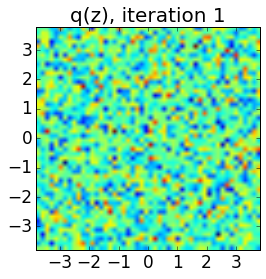

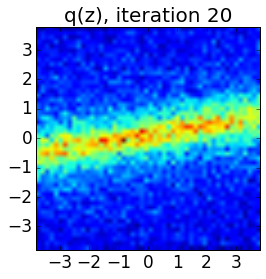

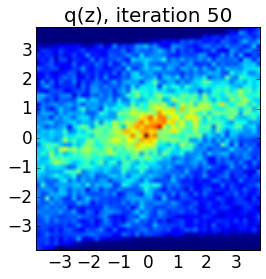

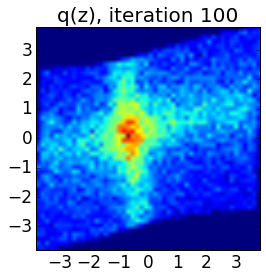

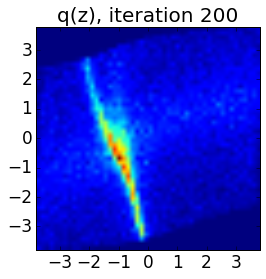

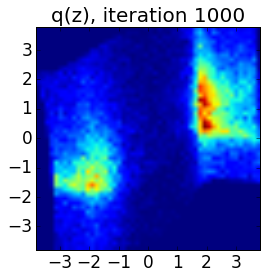

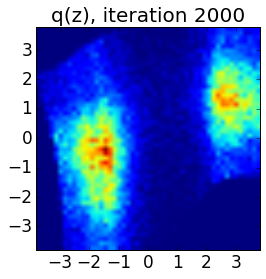

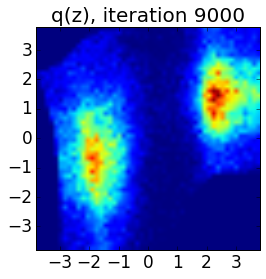

In [63]:
# optimised q(z)
print 'iters recorded : %s' % ziters
xlims = (-3.8,+3.8)
ylims = (-3.8,+3.8)
    
for idz, iditer in enumerate(ziters):
    zzz = record['zs'][idz]
    heatmap, xedges, yedges = np.histogram2d( zzz[:,0], zzz[:,1], bins=50)
    extent = [xlims[0], xlims[1], ylims[0], ylims[1]]
    plt.figure()
    plt.imshow(heatmap.T, extent=extent, origin='lower')
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.title('q(z), iteration %d' % (iditer+1), fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=17)
    if SAVE_FLAG:
        plt.savefig( FIG_PATH+'/evolve2/L%d_iter%d'%(NUM_LAYERS,iditer+1))

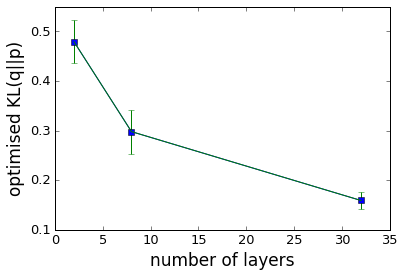

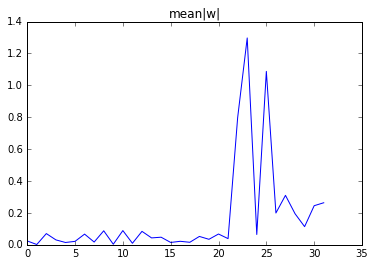

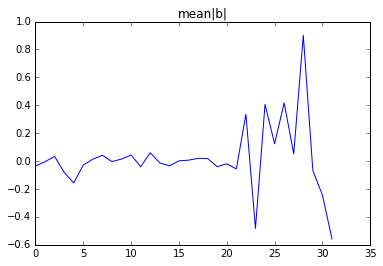

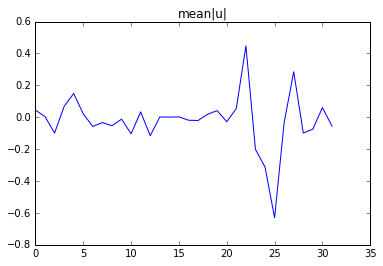

In [50]:
valuelst = iaf.getParamValues()
magnitudes = {'w':[],'b':[],'u':[]}
numl = 0
for i in range(0,len(valuelst),2):
    numl += 1
    magnitudes['w'].append( np.mean(abs(valuelst[i]['w'])) )
    magnitudes['b'].append( np.mean(valuelst[i]['b']) )
    magnitudes['u'].append( np.mean(valuelst[i]['u']) )
kkk = 'w'; plt.figure();plt.plot(np.arange(numl),magnitudes[kkk]); plt.title('mean|%s|'%kkk)
kkk = 'b'; plt.figure();plt.plot(np.arange(numl),magnitudes[kkk]); plt.title('mean|%s|'%kkk)
kkk = 'u'; plt.figure();plt.plot(np.arange(numl),magnitudes[kkk]); plt.title('mean|%s|'%kkk)
